# Project 2 : Predicting property price in 2017 Zillow data

23 January 2023

**This goal of this project is to _predict the property assessed tax values for single-family homes_ for Zillow in three counties in Southern California (Orange County, Los Angeles County, Ventura County), based on Zillow data for single-family homes that had transactions in 2017.**  

**This will be done in Python, using different statistical tests, modelling and graphs.**

 &emsp;

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from env import host, username, password, sql_connexion
import env

# import my functions
import project_2_acquire_zillow_function
import project_2_prepare_zillow_2017
import project_2_zillow_skbest_rfe_functions

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")


 &emsp;

## DATA ACQUISITION   

- Data was originally obtained from Zillow, and came to us here at Codeup via the Codeup SQL server.  
- The newly acquired dataframe represented 52_442 rows and 8 columns.  
- Each row represented a single-family home that had been sold in 2017.  
- Each column represented a different feature of the home — Zillow's parcel ID number for the property, the number of bathrooms or bedrooms in the house, its total liveable square footage, the transaction date, the FIPS / county code and the tax value of the house.

## DATA PREPARATION

- To prepare the data, it was necessary to drop any unnecessary, unhelpful or duplicated columns.
- At a later point, categorical columns were encoded, with dummy variables being created for each categorical feature.
- These dummy variables were then concatenated onto the prepared Zillow dataframe.
- Null values, being a very small percentage in the overall dataset, were dropped.
- The Zillow parcel ID and the the transaction date for the property were deemed irrelevant to this project and dropped. 
- Outliers were, above certain points, dropped. A few outliers remained, to allow for the accounting of the presence of extreme, yet present, values.
- Features specifically examined were the number of bathrooms in the house, the number of bedrooms in the house, the house's total liveable square footage and the FIPS / county code.
- These were analysed against the target variable of the tax value of the house.

### An initial look at the Zillow data

In [2]:
# # obtaining the prepared ZILLOW 2017 dataset

zil = pd.read_csv('zillow_sfh_2017_sold.csv')
zil = project_2_prepare_zillow_2017.prep_zillow(zil)
zil.head(1)

,num_ba,num_br,total_sqft,county_fips,tax_val
0,3.5,4.0,3100.0,6059,1023282.0


**NOTE : By setting the tax value at $2 million and above as the cutoff for outliers, we eliminated 2.67pc of the data. This was deemed insignificant.**

**After tidying, there are 52_104 rows and 5 columns.**

 &emsp;

### Now it's time to split into train, validate and test subsets.
## EXPLORE.

### Hypotheses


1.  
$H_{0}$ : The total square feet of the property has no influence on tax value.  
$H_{a}$ : The total square feet of the property has an influence on tax value.  


2.  
$H_{0}$ : Houses with less than 3 bathrooms have a similar tax value to houses with 3 or more bathrooms.  
$H_{a}$ : Houses with less than 3 bathrooms do not have a similar tax value to houses with 3 or more bathrooms.  


3.   
$H_{0}$ : Houses with less than 4 bedrooms have a similar tax value to houses with 4 or more bedrooms.  
$H_{a}$ : Houses with less than 4 bedrooms do not have a similar tax value to houses with 4 or more bedrooms.  


4.   
$H_{0}$ : County of property has no influence on tax value.  
$H_{a}$ : County of property has an influence on tax value.  




In [3]:
# splitting into train, val, test

train, val, test = project_2_prepare_zillow_2017.tts_zillow(zil)
train.shape, val.shape, test.shape

((28411, 5), (12177, 5), (10147, 5))

 &emsp;

## Explore : Visualisation & Statistical Testing

**Looking at the correlation of the feature variables and the target (tax value).**

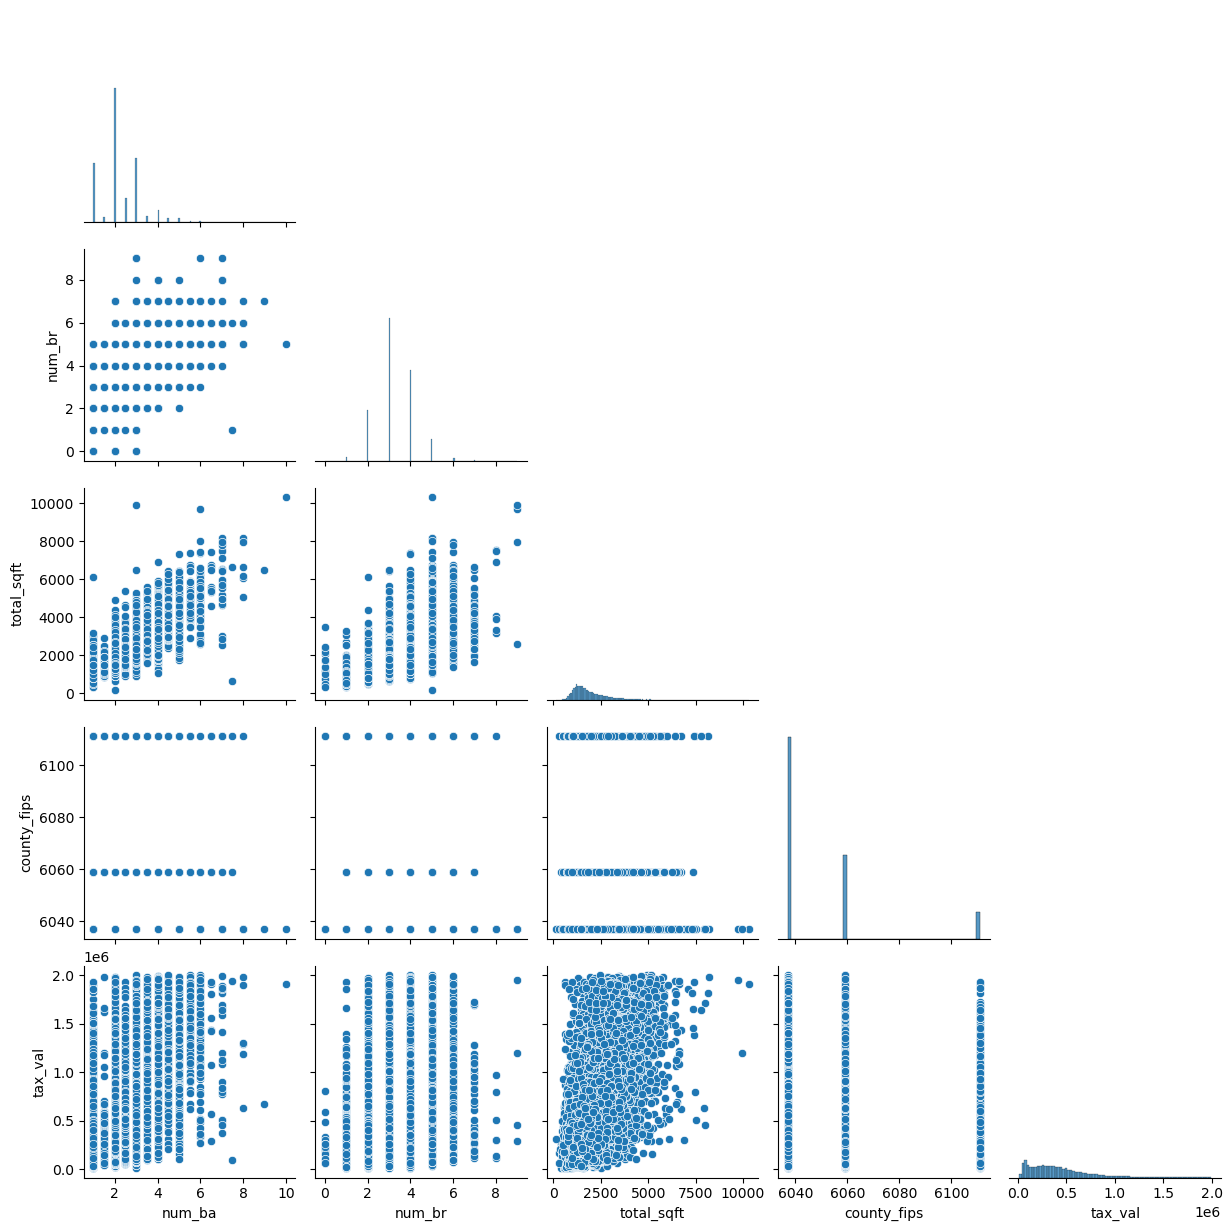

In [4]:
## looking at correlation

sns.pairplot(data = train, corner = True)
plt.show()

 &emsp;

**Looking at the correlation of the feature variables and the target in a numeric manner.**

In [5]:
# looking at correlation numerically

train_corr = train.corr()
train_corr

,num_ba,num_br,total_sqft,county_fips,tax_val
num_ba,1.000000,0.630670,0.836555,0.138586,0.516794
num_br,0.630670,1.000000,0.636355,0.151115,0.285905
total_sqft,0.836555,0.636355,1.000000,0.148769,0.579507
county_fips,0.138586,0.151115,0.148769,1.000000,0.099734
tax_val,0.516794,0.285905,0.579507,0.099734,1.000000


**TAKEAWAYS :**   

**Correletion is strong between total_sqft and num_ba.**  

**Correlation is moderate between tax_val and num_ba, tax_val and total_sqft, num_ba and num_br.**  

**Correlation is low for tax_val and num_br, county_fips and num_br, county_fips and num_ba, county_fips and total_sqft.**  

**Correlation is very low for county_fips and tax_val. This means that the connection between the county in which the property is located and its tax values are not very related to each other.**  

 &emsp;

### A heatmap is another way to visualise the relationship amongst variables.

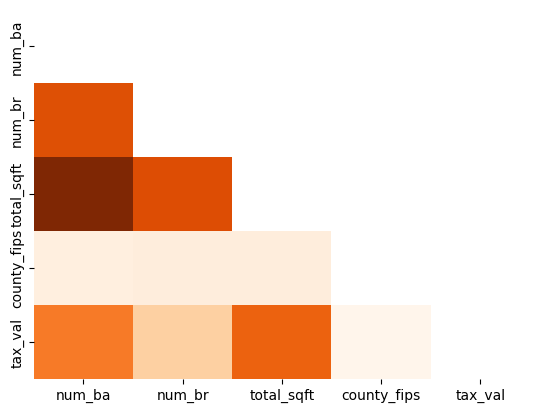

<Figure size 1500x1500 with 0 Axes>

In [6]:
# make a heatmap of con_corr

sns.heatmap(train.corr(), cmap = 'Oranges', cbar=False, annot_kws = {'fontsize' : 8}, mask = np.triu(train.corr()))

plt.figure(figsize = (15,15)) 

plt.show()

 &emsp;

## Graphing And Statistical Tests Of 4 Questions
**Here, we will use different types of graphs and statistical tests to determine the relationship between each feature variable and the target variable.**

### Question 1 : Does the total square footage of the home have a relationship to its tax value ?

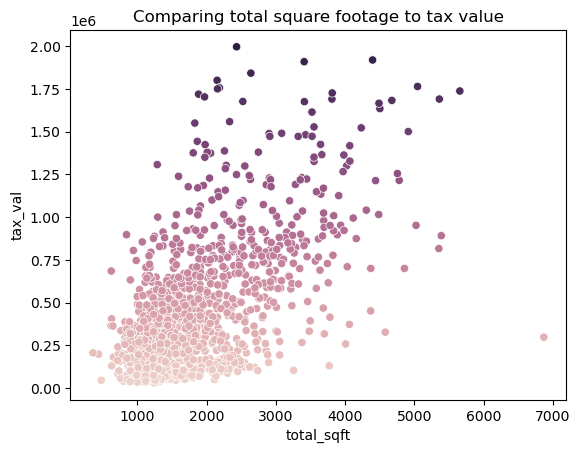

In [7]:
# plot the 'total_sqft' against target variable 'tax_value'

sns.scatterplot(x = 'total_sqft', y = 'tax_val', hue = 'tax_val', data = train.sample(1200))
plt.title('Comparing total square footage to tax value')

# removing the legend
plt.legend([],[], frameon = False)

plt.show()


**Takeaway :**  

**Looking at the scatterplot comparing the total square footage of the property to its tax value, it would appear that the majority of properties have total squre footage of less than 3000 sq ft, with the majority of these having a tax value of $1 million or less.**  

**Overall, the data appears to be relatively normally distributed.** 

 &emsp;

### Question 1 : Corresponding statistical test : total square footage to property tax value.

In [8]:
# setting the alpha value to 0.05

α = 0.05

In [9]:
# Use Pearson's R test (normally distribtued data) to calculate the correlation coefficient 
# and the p-value of total_sqft against tax_val

r_sf, p_value_sf = pearsonr(train.total_sqft, train.tax_val)
print(f'Correlation coefficient for property square footage and tax value: {round(r_sf, 4)}.\nP-value : {p_value_sf}.')


Correlation coefficient for property square footage and tax value: 0.5795.
P-value : 0.0.


**Takeaway :**
    
**Here, we used the Pearson's R statistical test, given that the data appeared relatively normally distributed.**  

**The test returns a coorelation coefficient of 0.5795, indicating moderate correlation. The p-value is 0, which would mean that we reject the null hypothesis : This indicates that there is a relationship between property total square footage and tax value.**

 &emsp;

### Question 2 : Do houses with three or more bathrooms have a similar tax value to houses with less than three bathrooms ?

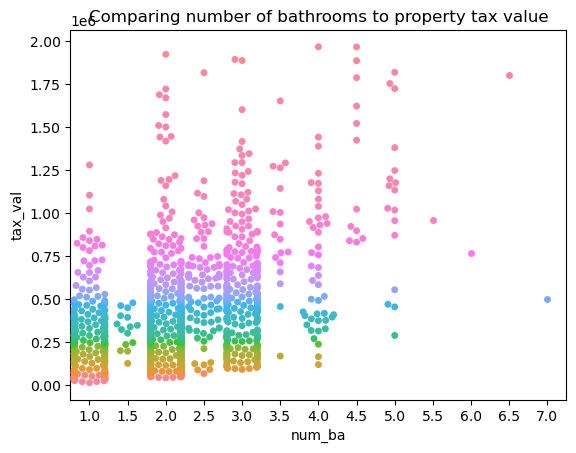

In [10]:
# plot the 'num_br' against target variable 'tax_value'

sns.swarmplot(x = 'num_ba', y = 'tax_val', data = train.sample(1200), hue = 'tax_val')
plt.title('Comparing number of bathrooms to property tax value')

# removing the legend
plt.legend([],[], frameon = False)

plt.show()

**Takeaway :**   

**Looking at the scatterplot comparing number of bathrooms to property tax value, it would appear that having 3 bathrooms leads the pack in driving tax value overall.**

**Overall, the data does not appear to be normally distributed.**

 &emsp;

### Question 2 : Corresponding statistical test : Property tax value of houses with less than 3 bathrooms to  property tax value of houses with 3 or more bathrooms : Independent, 2-Tailed T-Test.

In [11]:
# finding houses with 3 or more bathrooms

plus3 = train[train['num_ba'] >= 3].tax_val

# finding houses with less than 3 bathrooms 

less3 = train[train['num_ba'] < 3].tax_val

In [12]:
# checking variance between number of bathrooms and tax value

(plus3).var(), (less3).var()

(184392712688.6608, 73044869254.19215)

**Variance is hugely different.**

In [13]:
# assigning the variables 

t_ba, p_ba = stats.ttest_ind(plus3, less3, equal_var = False)
t_ba, p_ba

(63.91026064904359, 0.0)

In [14]:
# print statement for the t-test
α = 0.5

if p_ba > α :
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_ba, 3)}.')
elif t_ba < 0:
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_ba, 3)}.')
else:
    print(f'We reject the null hypothesis ; T-statistic of {round(t_ba, 3)}.')

We reject the null hypothesis ; T-statistic of 63.91.


**Takeaway :**
    
**Here, we used a two-tailed, independent T-test, given that the data consisted of discrete (number of bathrooms) and continuous (tax value) variables. The number of bathrooms was binned into bins consisting of properties with less than 3 bathrooms, and 3 or more bathrooms. These two bins were then compared to the tax value.**  

**The test returned a T-statistic of 63.91, indicating that there is a notable relationship between the number of bathrooms and the tax value. This would mean that that we reject the null hypothesis : There is relationship between number of bathrooms and tax value.**

 &emsp;

### Question 3 : Does the number of bedrooms in the home have a relationship to its tax value ?

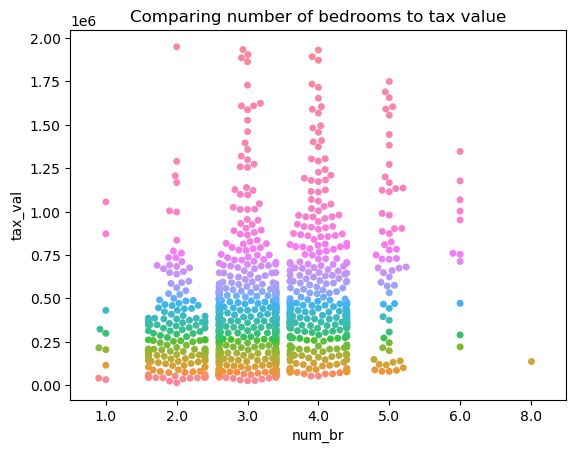

In [15]:
# plot the 'num_br' against target variable 'tax_value'

sns.swarmplot(x = 'num_br', y = 'tax_val', hue = 'tax_val', data = train.sample(1000))
plt.title('Comparing number of bedrooms to tax value')

# removing the legend
plt.legend([],[], frameon = False)

plt.show()


**Takeaway :**  

**The above scatterplot shows that hosues with 3 to 5 bedrooms are most common, followed by houses with 2 bedrooms. The tax value reaches highest for houses with 3 or 4 bedrooms, yet the overall relationship between number of bedrooms in relation to tax value appears rather week ; it would, almost, if read incorrectly, appear to indicate that having bedrooms drives down the tax value.**

**Overall, the data appears to be normally distributed.**

 &emsp;

### Question 3 : Corresponding statistical test : Property tax value of houses with less than 4 bedrooms to  property tax value of houses with 4 or more bedrooms : Independent, 2-Tailed T-test.

In [16]:
# finding houses with 3 or more bathrooms

plus4 = train[train['num_br'] >= 4].tax_val

# finding houses with less than 3 bathrooms 

less4 = train[train['num_br'] < 4].tax_val

In [17]:
# checking variance between number of bedrooms and tax value

(plus4).var(), (less4).var()

(163061321191.14404, 93210771521.75832)

**Variance is hugely different.**

In [18]:
t_br, p_br = stats.ttest_ind(plus4, less4, equal_var = False)

In [19]:
# print statement for the t-test

if p_br > α :
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_br, 3)}.')
elif t_br < 0:
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_br, 3)}.')
else:
    print(f'We reject the null hypothesis ; T-statistic of {round(t_br, 3)}.')

We reject the null hypothesis ; T-statistic of 41.26.


**Takeaway :**
    
**Here, we used a two-tailed, independent T-test, given that the data consisted of discrete (number of bedrooms) and continuous (tax value) variables. The number of bedrooms was binned into bins consisting of properties with less than 4 bedrooms, and 4 or more bedrooms. These two bins were then compared to the tax value.**  

**The test returned a T-statistic of 41.26, indicating that there is a relationship between the number of bedrooms and the tax value. Rhis would mean that that we would reject the null hypothesis : There is a very relationship between number of bedrooms and tax value.**

 &emsp;

### Question 4 : Does the county of the home have a relationship to the tax value ?

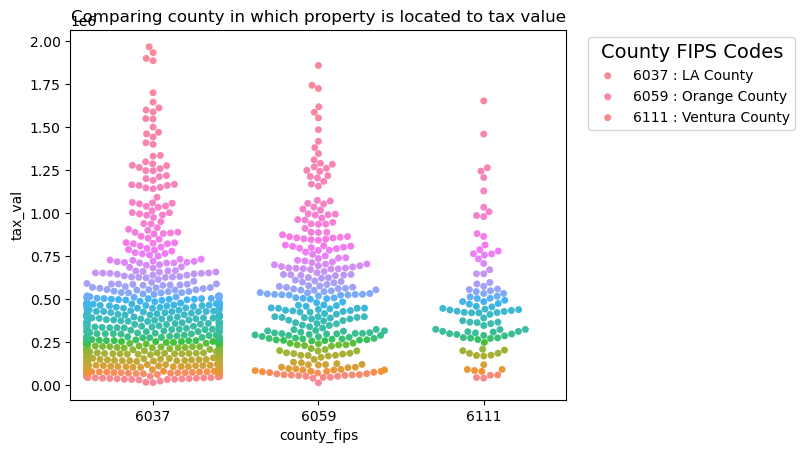

In [20]:
# plot the 'num_br' against target variable 'tax_value'

sns.swarmplot(x = 'county_fips', y = 'tax_val', hue = 'tax_val', data = train.sample(1000))
plt.title('Comparing county in which property is located to tax value')

# modifying the legend
plt.legend(['6037 : LA County', '6059 : Orange County', '6111 : Ventura County'], 
           bbox_to_anchor = (1.03, 1), title = 'County FIPS Codes', title_fontsize = 14)

plt.show()

# 6037  = LA County
# 6059 = Orange County
# 6111 = Ventura County

**Takeaway :**

**The majority of single-family homes in Los Angeles County tend towards a lower tax value overall, but LA County single-family home tax value also reaches the highest. Ventura County (6111) is relatively equally distributed below a tax value of about $1 million, with a few outliers at much higher values. Orange County (6059), is, like LA County, heavier on the lower tax values, but its lowest tax value is higher than LA County's lowest.**  

**Overall, the data does not appear to be normally distributed.**

 &emsp;

### Question 4 : Corresponding statistical test : location of property to property tax value : Independent T-test

In [22]:
# checking variance between number of bedrooms and tax value

(train.county_fips).var(), (train.tax_val).var()

(445.9981084661018, 127267990802.22897)

**Variance is hugely different.**

In [23]:
t_fips, p_fips = stats.ttest_ind(train.county_fips, train.tax_val, equal_var=False)
t_fips, p_fips

(-208.52481156424864, 0.0)

In [24]:
# print statement for the t-test

if p_fips > α :
    print('We fail to reject the null hypothesis.')
elif t_fips < 0:
    print(f'We fail to reject the null hypothesis ; T-statistic of {round(t_fips, 3)}.')
else:
    print('We reject the null hypothesis.')

We fail to reject the null hypothesis ; T-statistic of -208.525.


**Takeaway :**
    
**Here, we used a two-tailed, independent T-test, given that the data consisted of discrete (county FIPS code) and continuous (tax value) variables.**  

**The test returned a very low (-208.53) T-statistic, indicating that there is a highly significant difference in the relationship between the two. Because the T-statistic is so low, this would mean that that we would fail to reject the null hypothesis : This indicates that there is a only a very distant relationship between the county FIPS code and the tax value.**

 &emsp;

## Overall Exploration Takeaways

**Visually, the data would seem to indicate a range of correlations and distributions between the feature variables and the target variable of property tax value ('tax_val'). For this reason, both Independent T-tests and a Pearson's R test were run.** 

**Statistical testing using Independent, 2-tailed T-tests on each of the discrete feature values of number of bedrooms and number of bathrooms after binning (houses with 3 or more bathrooms or less than 3 bathrooms ; and houses with 4 or more bedrooms or less than 4 bedrooms) indicated that there was a relationship between number of bathrooms or number of bedrooms and tax value.**

**The county FIPS code appeared, based on Independent, 2-Tailed T-statistical testing, to have little relationship to property tax value.**

**There is a moderate correlation (correlation coefficient of 0.5795) between total square footage of the home and its tax value. Given the continuous category of both variables, the Pearson's R test was used here.**

**Moving forward, we will not drop any of the features, because of the limited number of statistical results.**

 &emsp;

## Feature Engineering

**Target variable (y-value) is 'tax_val'.**

**Using SelectKBest, we will determine the feature variables that have the most influence on the target variable.**

In [25]:
# finding the SelectKBest

project_2_zillow_skbest_rfe_functions.select_best(train, ['total_sqft', 'num_ba', 'num_br'], 'tax_val', 2)

Index(['total_sqft', 'num_ba'], dtype='object')

**Takeaway : The SelectKBest statistical test shows that total square footage of the house and its number of bathrooms have the closest relationship to the target variable of tax value.**

 &emsp;

**Using Recursive Feature Engineering, we will determine the feature variables that contribute the most to the predictive machine learning model.**

In [26]:
# finding the RFE
# not scaling any of the columns

rfe = project_2_zillow_skbest_rfe_functions.rfe_function(train, 2, 'tax_val', [])
rfe

,ranking,feature
0,1,num_ba
1,1,num_br
3,2,county_fips
2,3,total_sqft


**Takeaway : The RFE statistical test shows that the number of bathrooms in the house and the number of bedrooms  have the closest relationship to the target variable of tax value.**

 &emsp;

In [27]:
# split train, val, test into X_train, X_val, X_test and y-train, etc

X_train, y_train, X_val, y_val, X_test, y_test = project_2_prepare_zillow_2017.tts_xy(train, 
                                                                                      val, test, 'tax_val')

 &emsp;

## Linear Regression Model

In [28]:
# transforming y_train, y_val into DFs to allow for Linear Regression modelling

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

In [29]:
# finding the median of y_train & y_val

tax_pred_median = round(y_train['tax_val'].median())

# adding the predicted median column onto the y_ DFs
y_train['tax_val_pred_median'] = tax_pred_median
y_val['tax_val_pred_median'] = tax_pred_median



In [30]:
# finding the mean of y_train & y_val

tax_pred_mean = round(y_train['tax_val'].mean())

# adding the predicted mean column onto the y_ DFs
y_train['tax_val_pred_mean'] = tax_pred_mean
y_val['tax_val_pred_mean'] = tax_pred_mean

In [31]:
# Compute the RMSE comparing actual tax_val to tax_pred_mean.

rmse_train_mean = mean_squared_error(y_train['tax_val'], y_train['tax_val_pred_mean']) ** 0.5

rmse_val_mean = mean_squared_error(y_val['tax_val'], y_val['tax_val_pred_mean']) ** 0.5


print(f'The RMSE of the train dataset on the mean is {round(rmse_train_mean)} USD.')
print(f'The RMSE of the validate dataset on the mean is {round(rmse_val_mean)} USD.')

The RMSE of the train dataset on the mean is 356740 USD.
The RMSE of the validate dataset on the mean is 356668 USD.


In [32]:
# Compute the RMSE comparing actual tax_val to tax_pred_median.

rmse_train_med = mean_squared_error(y_val['tax_val'], y_val['tax_val_pred_median']) ** 0.5

rmse_val_med = mean_squared_error(y_val['tax_val'], y_val['tax_val_pred_median']) ** 0.5


print(f'The RMSE of the train dataset on the median is {round(rmse_train_med)} USD.')
print(f'The RMSE of the validate dataset on the median is {round(rmse_val_med)} USD.')

The RMSE of the train dataset on the median is 366245 USD.
The RMSE of the validate dataset on the median is 366245 USD.


**TAKEAWAY : The Root Mean Square Error of the mean on the training dataset (356_740 USD) was lower than the RMSE of the median on the train dataset, so we will be setting the RMSE of the mean as the baseline.**

In [33]:
# setting the baseline to equal 'rmse_train_mean'

y_train['baseline'] = round(rmse_train_mean)

# dropping columns that are no longer necessary 
y_train = y_train.drop(columns = ['tax_val_pred_median', 'tax_val_pred_mean'])

 &emsp;

## MODELLING : Ordinary Least Squares 

**Examining the number of bathrooms against the tax value of the house.**

In [34]:
# fitting the OLS model to 'total_sqft' against 'tax_val'
ols_model = LinearRegression().fit(train[['total_sqft']], train[['tax_val']])

# adding the yhat column to the train DF
train['yhat'] = ols_model.predict(train[['total_sqft']])

# compute the y-hat baseline from 'tax_val'

train['yhat_baseline'] = round(train['tax_val'].mean())


In [35]:
# looking at what's in train

train.head(1)

,num_ba,num_br,total_sqft,county_fips,tax_val,yhat,yhat_baseline
20986,3.0,3.0,2521.0,6037,464525.0,610248.807931,447390


In [36]:
# setting a baseline

baseline = train['tax_val'].mean()
train['baseline'] = baseline

In [37]:
# calculating the residuals, to detrmine how far the baseline is from the actual

train['yhat_residual'] = train['yhat'] - train['tax_val']
train['baseline_res'] = train['yhat_baseline'] - train['tax_val'] 


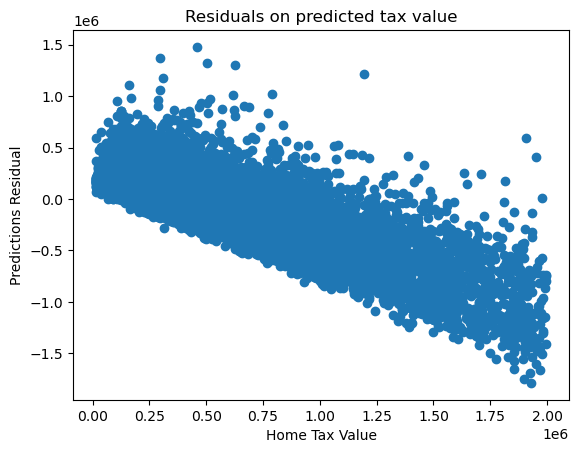

In [38]:
## make a scatter plot of the model's prediction on the actual tax value in relation to the predicted

plt.scatter(x = train['tax_val'], y = train['yhat_residual'])

plt.xlabel('Home Tax Value')
plt.ylabel('Predictions Residual')
plt.title('Residuals on predicted tax value')
plt.show()

**TAKEAWAY : We can see that there is a rather consistent downslope for the residuals on the predicted tax value a the tax value of the home increases.**

 &emsp;

In [39]:
# compute the Sum of Squared Errors (multiplying by the number of entries in the DF)

sse = mean_squared_error(train['tax_val'], train['yhat']) * len(train)
                               
sse_baseline = mean_squared_error(train['tax_val'], train['yhat_baseline']) * len(train)


print(f'The sum of squared errors of the train dataset is {sse}.') 
print(f'The SSE of the train dataset baseline is {sse_baseline}.') 

The sum of squared errors of the train dataset is 2401434703025106.0.
The SSE of the train dataset baseline is 3615683618691319.0.


In [40]:
# the mean of squared errors

mse = mean_squared_error(train['tax_val'], train['yhat'])
mse_baseline = mean_squared_error(train['tax_val'], train['yhat_baseline']) 

print(f'The mean of squared errors of the train dataset is {mse}.') 
print(f'The MSE of the train dataset baseline is {mse_baseline}.') 

The mean of squared errors of the train dataset is 84524821478.48038.
The MSE of the train dataset baseline is 127263511269.97708.


In [41]:
# the root of mean of squared errors

rmse = sqrt(mean_squared_error(train['tax_val'], train['yhat']))
rmse_baseline = sqrt(mean_squared_error(train['tax_val'], train['yhat_baseline']))

print(f'The root of mean of squared errors of the train dataset is {round(rmse, 4)}.') 
print(f'The RMSE of the train dataset baseline is {round(rmse_baseline, 4)}.') 

The root of mean of squared errors of the train dataset is 290731.5282.
The RMSE of the train dataset baseline is 356740.1173.


In [42]:
evs = explained_variance_score(train['tax_val'], train['yhat'])

print(f'The explained variance of the model from the actual data is {round(evs, 4)}.')
# how effectively the trend line from the modelling is describing the data

The explained variance of the model from the actual data is 0.3358.


In [43]:
# finding the best model for the above metrics

train_eval = pd.DataFrame(np.array(['SSE', 'MSE', 'RMSE']), columns = ['metric_used'])

train_baseline_eval = pd.DataFrame(np.array(['SSE_baseline', 'MSE_baseline', 'RMSE_baseline']), columns = ['metric_used'])

train_eval['model_error'] = np.array([sse, mse, rmse])

train_baseline_eval['model_error'] = np.array([sse_baseline, mse_baseline, rmse_baseline])

print(train_eval)
print()
print(train_baseline_eval)

  metric_used   model_error
0         SSE  2.401435e+15
1         MSE  8.452482e+10
2        RMSE  2.907315e+05

     metric_used   model_error
0   SSE_baseline  3.615684e+15
1   MSE_baseline  1.272635e+11
2  RMSE_baseline  3.567401e+05


In [44]:
# visualising the amount of error in a DF

train_eval['error_amount'] = train_eval['model_error'] - train_baseline_eval['model_error']
train_eval

,metric_used,model_error,error_amount
0,SSE,2.401435e+15,-1.214249e+15
1,MSE,8.452482e+10,-4.273869e+10
2,RMSE,2.907315e+05,-6.600859e+04


**Takeaway : The SSE has the smallest model error amount, slightly below the baseline. This metric, because it respects the outliers, is deemed the most appropriate.**

 &emsp;

##  MODELLING : Lasso + Lars

In [45]:
#establishing linear regression model

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [46]:
# making dummies
zil = pd.get_dummies(zil, columns = ['num_ba', 'num_br', 'county_fips'])

In [47]:
# splitting into train, val, test based on zil DF with dummies

train, val, test = project_2_prepare_zillow_2017.tts_zillow(zil)
train.shape, val.shape, test.shape

((28411, 34), (12177, 34), (10147, 34))

In [48]:
# split train, val, test into X_train, X_val, X_test and y-train, etc

X_train, y_train, X_val, y_val, X_test, y_test = project_2_prepare_zillow_2017.tts_xy(train, 
                                                                                      val, test, 'tax_val')

In [94]:
# using Lasso + Lars model
lal = LassoLars(alpha = 0.05)

# fitting to 
lal.fit(X_train, y_train)

# predict on X_train
lal_pred = lal.predict(X_train)

In [95]:
# making a DF of the predictions based on y_train

prediction_df = pd.DataFrame({'actual' : y_train,
                              'lasso_predictions' : lal_pred})
prediction_df.head(2)

,actual,lasso_predictions
20986,464525.0,612479.894283
17998,879359.0,616895.205008


In [96]:
# get the square root of the rmse of the actual values and the predictions

lal_rmse = sqrt(mean_squared_error(prediction_df['lasso_predictions'], prediction_df['actual']))
lal_rmse

283163.96226582624

**Takeaway : The RMSE indicates a magnitude of error of about 238_163 from the Lasso + Lars prediction.**

In [54]:
# finding the mean of the y_train 

y_train.mean()

447389.9895463025

 &emsp;

## MODELLING : Generalised Linear Model (TweedieRegressor)

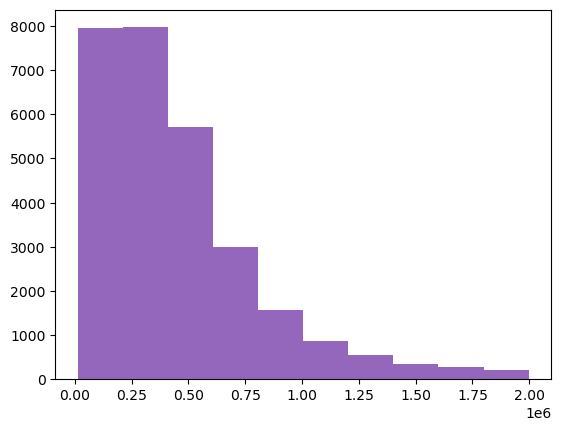

In [59]:
# plotting to look at the data

plt.hist(y_train)
plt.show()

**This distribution appears to be of the gamma type, so we will set our GLM to the power the power of 2.**

In [60]:
# setting and fitting the TweedieRegressor

tweed = TweedieRegressor(power = 2)
tweed.fit(X_train, y_train)

TweedieRegressor(power=2)

In [63]:
# predicting on X_train
prediction_df['tweedie'] = tweed.predict(X_train)
prediction_df.head(2)

,actual,lasso_predictions,tweedie
20986,464525.0,612385.923186,560522.651145
17998,879359.0,616866.295102,536048.363799


In [64]:
# cheking the error

tweed_rmse = sqrt(mean_squared_error(prediction_df['tweedie'], prediction_df['actual']))

print(f'The Generalised Linear Model has an RMSE of {round(tweed_rmse, 4)}.')

The Generalised Linear Model has an RMSE of 362181.1157.


 &emsp;


**Now that we have realised 3 models, we will put them into a dataframe and compare the results.**

In [65]:
# making a DF of the 3 models (OLS, Lasso + Lars, TweedieRegressor)

pd.DataFrame({'Model' : ['Linear OLS', 'LassoLars','Tweedie Regressor'], 
              'RMSE' : [rmse, lal_rmse, tweed_rmse]})

,Model,RMSE
0,Linear OLS,290731.528181
1,LassoLars,283163.998778
2,Tweedie Regressor,362181.115727


In [99]:
# appending the OLS results onto the prediction_df DF

prediction_df['ols'] = ols_model.predict(train[['total_sqft']])

In [100]:
# appending the baseline results onto the dataframe

prediction_df['baseline'] = baseline
prediction_df.head(21)

,actual,lasso_predictions,baseline,ols
20986,464525.0,612479.894283,447389.989546,605510.843241
17998,879359.0,616895.205008,447389.989546,563486.732353
40409,84214.0,295222.878885,447389.989546,299990.726726
13509,56483.0,289930.141349,447389.989546,293952.779759
29555,125389.0,330366.656122,447389.989546,340082.694585
16998,50405.0,325287.485869,447389.989546,283809.028855
7792,149483.0,608994.048178,447389.989546,719024.246216
47632,388347.0,353443.175712,447389.989546,329214.390045
47510,768000.0,416975.388161,447389.989546,449490.293622
18221,451000.0,262831.509099,447389.989546,225844.737975


In [68]:
# finding the error cf the baseline

sqrt(mean_squared_error(prediction_df['actual'], prediction_df['baseline']))

356740.1172702293

**The output number shows (356_740 USD) that we beat the baseline (447_389 USD) in all of our models.**

 &emsp;

## USING THE BEST TWO MODEL ON THE VALIDATE DATASET

**The best models were found to be the Lasso + Lars model and the OLS model.**

In [69]:
# using Lasso + Lars model
lal2 = LassoLars(alpha = 0.13)

# fitting to 
lal2.fit(X_val, y_val)

# predict on X_train
lal_pred2 = lal2.predict(X_val)

In [74]:
# making a DF of the predictions based on y_train

val_preds = pd.DataFrame({'actual' : y_val,
                          'lasso_val_preds' : lal_pred2})
val_preds.head(3)

,actual,lasso_val_preds
17518,227350.0,564456.778449
20293,807123.0,435142.030683
30280,249447.0,382169.967528


In [75]:
# get the square root of the rmse of the actual values and the predictions

lal_rmse2 = sqrt(mean_squared_error(val_preds['lasso_val_preds'], val_preds['actual']))
lal_rmse2


284051.0084026474

In [76]:
# finding the mean of the y_train 

y_val.mean()

447396.9998357559

**Now that we've run the Lasso + Lars test on the validate dataset, we will compare the results with the training dataset.**

In [86]:
# make a DF of LL RMSE train and LL RMSE val

pd.DataFrame({'lasso_train_rmse' : [lal_rmse], 'lasso_val_rmse' : [lal_rmse2], 'baseline' : [baseline]})

,lasso_train_rmse,lasso_val_rmse,baseline
0,283163.998778,284051.008403,447389.989546


**TAKEAWAY :**  

**The RMSE of the Lasso + Lars model on the training dataset has an RMSE of 283,163 USD. On the validation (out-of-sample) dataset, the RMSE using Lasso + Lars is 284,051 USD, which is a minimal difference of only 888 USD more than on the training dataset.**   

**From this, we can see that the Lasso + Lars model is consistent in its predictions.**
 
 



 &emsp;

### Now we will run the VALIDATE dataset against the OLS Linear Regression model

In [78]:
# using OLS


# fitting the OLS model to 'total_sqft' against 'tax_val'
ols_model = LinearRegression().fit(val[['total_sqft']], val[['tax_val']])

# predicting on total_sqft after it's been fit
ols_val = ols_model.predict(val[['total_sqft']])

In [79]:
# resetting y_val index 

y_val.index.sort_values()

y_val.reset_index(drop = True, inplace = True)

In [80]:
#making new df for ols validate

ols_df = pd.DataFrame(ols_val)
ols_df['y_val'] = y_val

In [81]:
# renaming the columns

ols_df.rename(columns = {0 : 'ols_val_preds', 'y_val' : 'actual'}, inplace = True)
ols_df.head(2)

,ols_val_preds,actual
0,617103.701418,227350.0
1,439105.024839,807123.0


In [82]:
# get the square root of the rmse of the actual values and the predictions

rmse2 = sqrt(mean_squared_error(ols_df['ols_val_preds'], ols_df['actual']))

# vsualising the RMSE OLS DF

pd.DataFrame({'ols_train_rmse' : [rmse], 'ols_val_rmse' : [rmse2]})

,ols_train_rmse,ols_val_rmse
0,290731.528181,291991.251301


**TAKEAWAY :** 

**On the OLS model run on the validate dataset, the RMSE was 1260 USD higher than on the training dataset, a negligible difference.**  

**However, the error on the Lasso + Lars model was still smaller in both cases.**

 &emsp;


## MODELLING TAKEAWAYS

**In the modelling process, we used three different tests : OLS / Linear Regression, Lasso + Lars and the Generalised Linear Model (TweedieRegressor).**   

**The Ordinary Least Squares and the Lasso + Lars models had the best results as compared with the baseline for both the train and the validate datasets. The modelling results for the analysis of the validate dataset led it to be shown that neither model was overfit.**

**Overall, the Lasso + Lars had the most accurate results of the three tests, with an RMSE of 283_163 USD on the training dataset. On the validation (out-of-sample) dataset, the RMSE using Lasso + Lars was 284_051 USD, which is a minimal difference of only 888 USD more than on the training dataset.**   

 &emsp;

### Having determined the _best model_ (LASSO + LARS), here below is a histogram plotting the actual tax value to the predicted tax value, using the test dataset.

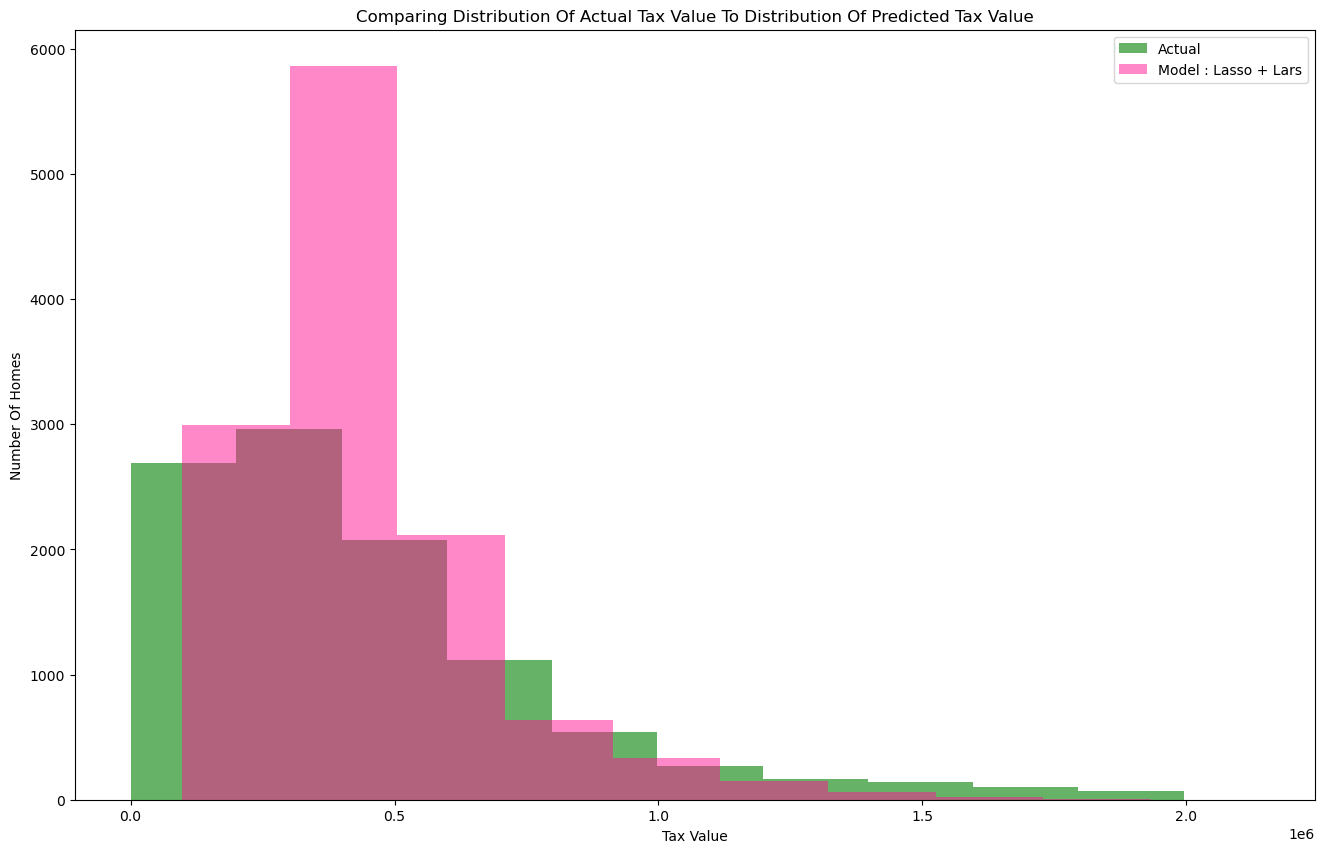

In [83]:
# plot to visualize actual vs predicted tax values

plt.figure(figsize = (16, 10))
plt.hist(y_test, color = 'green', alpha = 0.6, label= 'Actual')
plt.hist(lal_pred2, color = 'deeppink', alpha = 0.5, label = 'Model : Lasso + Lars')
plt.title('Comparing Distribution Of Actual Tax Value To Distribution Of Predicted Tax Value')

plt.xlabel('Tax Value')
plt.ylabel('Number Of Homes')
plt.legend()
plt.show()


 &emsp;

## CONCLUSIONS

### EXPLORATION AND STATISTICAL TESTING

**Visually, the data indicated a range of correlations and distributions between the feature variables and the target variable of property tax value ('tax_val'). For this reason, both Independent T-tests and a Pearson's R test were run.**  

**Independent statistical testing after binning on the number of bedrooms and the number of bathrooms indicated a relationship between the features and the target.**  

**The square footage of the home also had a statistically significant relationship to its tax value.**  

### MODELLING

**Three different tests were used : OLS / Linear Regression, Lasso + Lars and the Generalised Linear Model (TweedieRegressor).**  

**The Ordinary Least Squares and the Lasso + Lars models had the best results as compared with the baseline for both the train and the validate datasets. Neither model was overfit.**

**Overall, the Lasso + Lars had the most accurate results of the three tests. This model was selected to visualise the test dataset.**
 


 &emsp;

## RECOMMENDATIONS AND NEXT STEPS

### RECOMMENDATIONS

**In order to improve predictions in the future, obtain more consistent data on number of car-spaces in the garage, and more importantly, whether there is a garage at the property. This would allow for more refined testing.**

### NEXT STEPS

**Determine, using data manipulation (binning), visualisations and testing, whether the month in which the property were sold had any relationship to the property's tax value.**

**The features analysed in this project were those which had a sufficient ratio of data to the overall dataset. Other features that could have been interesting to analyse included number of car-spaces in a garage, and number of stories to the house. Unfortunately, these had too many null values — nearly 37pc in some cases.**  

**Explore the difference between 2016 and 2017 data using the same features (ba, br, sqft, fips) and target (tax value), and the 2017 and 2018 data.** 

 &emsp;